<a href="https://colab.research.google.com/github/PilaData/Aircraft-dents-detection-/blob/master/Detectrone_%2B_Mask_R_CNN_VF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-bqgu5muj
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-bqgu5muj
     |████████████████████████████████| 276kB 11.5MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1-cp36-none-any.whl size=44904 sha256=6bc84d6fb265a8a0957f6101890d0a70f659961ae6f07c7d6da2a779feec4641
  Stored in directory: /tmp/pip-ephem-wheel-cache-le3zcwdp/wheels/48/53/79/3c6485543a4455a0006f5db590ab9957622b6227011941de06
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=70af03d3e1f9128fe52dfb049b09777956e3ac8ec6e36591e1cc57ae188a30bf
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfull

In [ ]:
!wget https://www.dropbox.com/s/k71drla863ux2y5/Data1.zip?dl=0  -O Data1.zip
!unzip Data1.zip

--2020-06-17 18:49:24--  https://www.dropbox.com/s/k71drla863ux2y5/Data1.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.1, 2620:100:6031:1::a27d:5101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/k71drla863ux2y5/Data1.zip [following]
--2020-06-17 18:49:25--  https://www.dropbox.com/s/raw/k71drla863ux2y5/Data1.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucef862e8dead2fcc6d0ce0be7e5.dl.dropboxusercontent.com/cd/0/inline/A52CtUhN6RV2wYJ_MUVUTfqcaOo8h2r_CGvv7U3pPoOQBskqSWSoq4cXCmiIuKjQr4adN7UaHSg6A7ssPHm14ZVVxqpD5IFxqAaESl9m1TVqqyvYWsMrwRlWXIISN2cJdfs/file# [following]
--2020-06-17 18:49:25--  https://ucef862e8dead2fcc6d0ce0be7e5.dl.dropboxusercontent.com/cd/0/inline/A52CtUhN6RV2wYJ_MUVUTfqcaOo8h2r_CGvv7U3pPoOQBskqSWSoq4cXCmiIuKjQr4adN7UaHSg6A7ssPHm14ZVVxqpD5IFxqAaESl9m1TVqqyvYWsM

In [ ]:
###import os
import numpy as np
import json
from detectron2.structures import BoxMode

def get_microcontroller_dicts(directory):
    classes = ['Dent']
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])
        
        record["file_name"] = filename
        record["height"] = 600
        record["width"] = 800
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']]
            py = [a[1] for a in anno['points']]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train", "val"]:
    DatasetCatalog.register("Data_" + d, lambda d=d: get_microcontroller_dicts('/content/Data/' + d))
    MetadataCatalog.get("Data_" + d).set(thing_classes=['Dent'])
microcontroller_metadata = MetadataCatalog.get("Data_train")

In [ ]:
from detectron2.data.datasets import register_coco_instances

for d in ["train", "val"]:
    register_coco_instances(f"Data_{d}", {}, f"/content/Data/{d}.json", f"/content/Data/{d}")

In [ ]:
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import glob

import os
import ntpath
import numpy as np
import cv2
import random
import itertools
import pandas as pd
from tqdm import tqdm
import urllib
import json
import PIL.Image as Image

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:
cfg = get_cfg()

cfg.merge_from_file(
  model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
  )
)

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
  "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
)

In [ ]:
cfg.DATASETS.TRAIN = ("Data_train",)
cfg.DATASETS.TEST = ("Data_val",)
cfg.DATALOADER.NUM_WORKERS = 4

In [ ]:
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05

In [ ]:

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

cfg.TEST.EVAL_PERIOD = 500

In [8]:

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

cfg.TEST.EVAL_PERIOD = 500

[06/17 19:01:11 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_2d9806.pkl: 431MB [02:02, 3.52MB/s]                           
Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model!
Unable to load 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model!
Unable to load 'roi_heads.mask_head.predictor.bias' to the model due to incompatible shapes: (80,) in the checkpoint but (1,) in the model!


[06/17 19:03:22 d2.engine.train_loop]: Starting training from iteration 0
[06/17 19:04:14 d2.utils.events]:  eta: 1:06:00  iter: 19  total_loss: 1.859  loss_cls: 0.685  loss_box_reg: 0.343  loss_mask: 0.691  loss_rpn_cls: 0.150  loss_rpn_loc: 0.011  time: 2.6482  data_time: 0.0349  lr: 0.000020  max_mem: 9395M
[06/17 19:05:07 d2.utils.events]:  eta: 1:05:10  iter: 39  total_loss: 1.612  loss_cls: 0.502  loss_box_reg: 0.372  loss_mask: 0.668  loss_rpn_cls: 0.100  loss_rpn_loc: 0.009  time: 2.6507  data_time: 0.0107  lr: 0.000040  max_mem: 9395M
[06/17 19:06:01 d2.utils.events]:  eta: 1:03:46  iter: 59  total_loss: 1.585  loss_cls: 0.392  loss_box_reg: 0.524  loss_mask: 0.629  loss_rpn_cls: 0.074  loss_rpn_loc: 0.008  time: 2.6532  data_time: 0.0110  lr: 0.000060  max_mem: 9395M
[06/17 19:06:55 d2.utils.events]:  eta: 1:03:08  iter: 79  total_loss: 1.559  loss_cls: 0.363  loss_box_reg: 0.562  loss_mask: 0.561  loss_rpn_cls: 0.028  loss_rpn_loc: 0.009  time: 2.6638  data_time: 0.0159  lr:

In [9]:
%load_ext tensorboard

In [10]:
%tensorboard --logdir output

<IPython.core.display.Javascript object>

In [16]:
dataset_dicts = DatasetCatalog.get("Data_val")

WARNING [06/17 20:48:25 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/17 20:48:25 d2.data.datasets.coco]: Loaded 8 images in COCO format from /content/Data/val.json


In [17]:
Data_metadata = MetadataCatalog.get("Data_val")

In [23]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("V", )
predictor = DefaultPredictor(cfg)

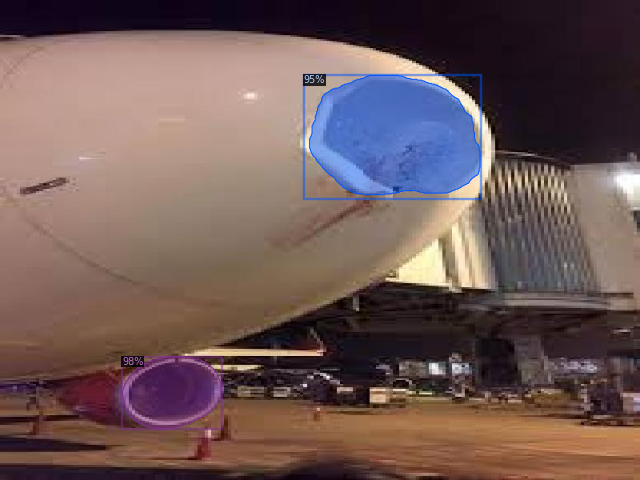

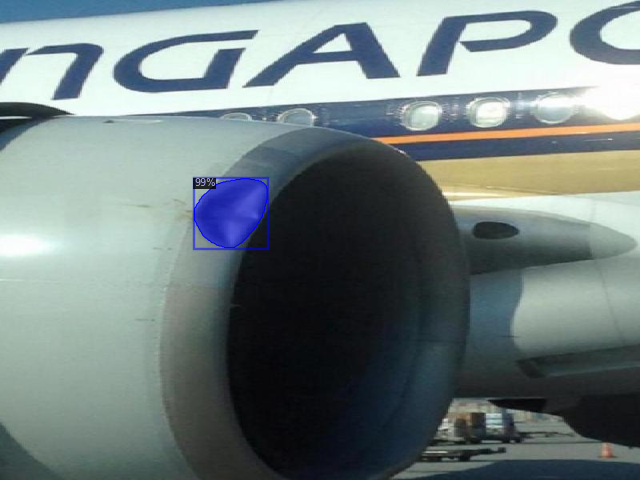

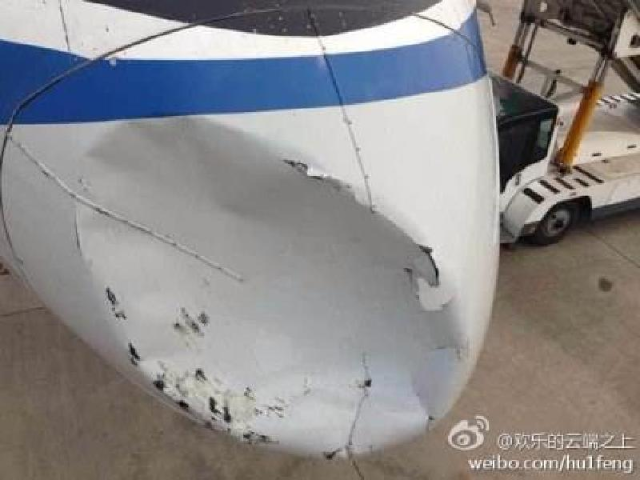

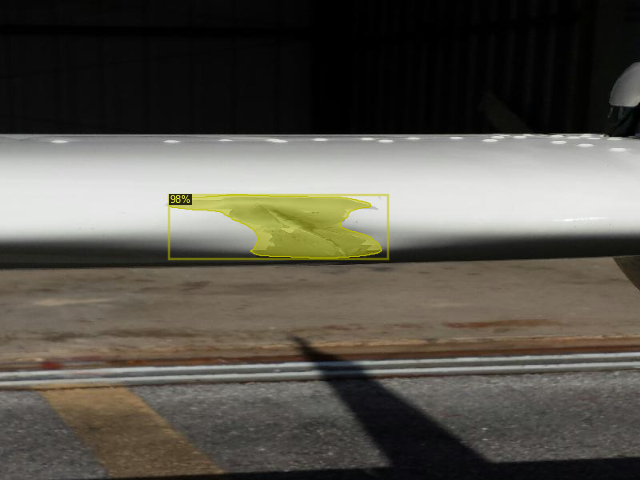

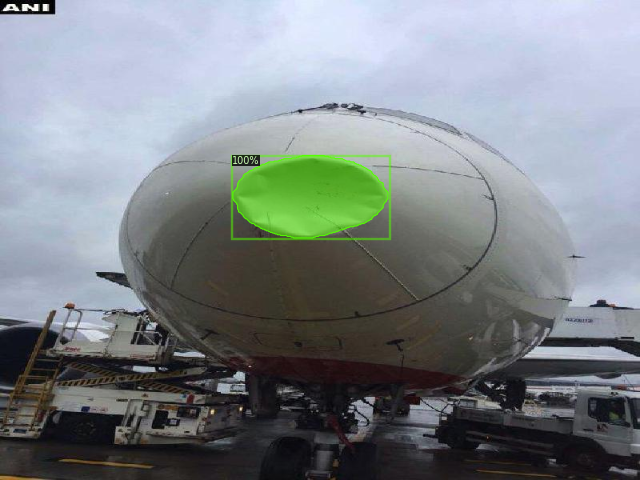

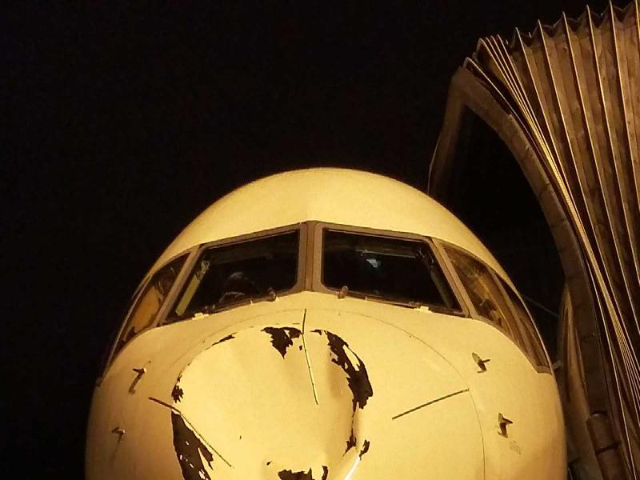

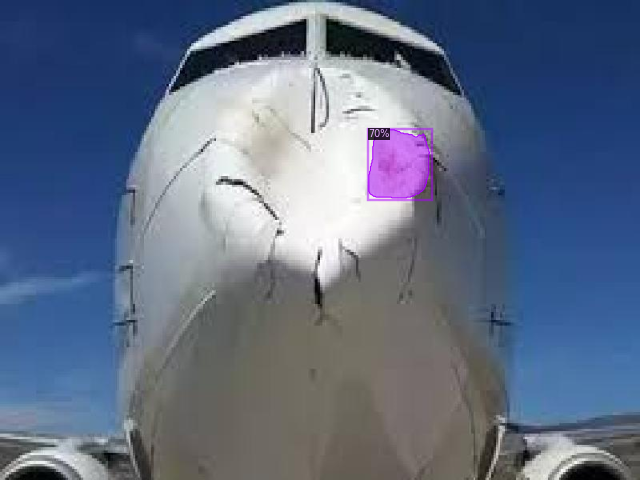

In [24]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os
import random
from detectron2.utils.visualizer import Visualizer
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import ColorMode
import random
from detectron2.utils.visualizer import Visualizer
from google.colab.patches import cv2_imshow

for d in random.sample(dataset_dicts, 7):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=Data_metadata, 
                   scale=0.8, 
                   
      )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [25]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)

In [26]:
  evaluator = COCOEvaluator("Data_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "Data_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [06/17 20:58:03 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/17 20:58:03 d2.data.datasets.coco]: Loaded 8 images in COCO format from /content/Data/val.json
[06/17 20:58:03 d2.data.common]: Serializing 8 elements to byte tensors and concatenating them all ...
[06/17 20:58:03 d2.data.common]: Serialized dataset takes 0.00 MiB
[06/17 20:58:03 d2.evaluation.evaluator]: Start inference on 8 images
[06/17 20:58:06 d2.evaluation.evaluator]: Total inference time: 0:00:00.887970 (0.295990 s / img per device, on 1 devices)
[06/17 20:58:06 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.251794 s / img per device, on 1 devices)
[06/17 20:58:06 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/17 20:58:06 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[06/17 20:58:06 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading

OrderedDict([('bbox',
              {'AP': 51.32343234323431,
               'AP50': 68.11881188118811,
               'AP75': 52.145214521452154,
               'APl': 45.86562942008486,
               'APm': 89.99999999999999,
               'APs': nan}),
             ('segm',
              {'AP': 46.44224422442244,
               'AP50': 68.11881188118811,
               'AP75': 46.20462046204621,
               'APl': 42.97029702970297,
               'APm': 89.99999999999999,
               'APs': nan})])